In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# Load .mat data
data = scipy.io.loadmat(r'C:\Users\18216\Desktop\UC_train_test_case9.mat')

X_train = torch.tensor(data['X_train'], dtype=torch.float32)  # shape: [N, N_d, 24]
Y_train = torch.tensor(data['Y_train'], dtype=torch.float32)  # shape: [N, N_g, 24]
X_test = torch.tensor(data['X_test'], dtype=torch.float32)
Y_test = torch.tensor(data['Y_test'], dtype=torch.float32)
        
def calculate_violation_rate(X, Y, tolerance=5e-4):
    """
    Calculate power balance violation rate for raw UC data.
    
    Args:
        X: Demand data [num_buses, num_hours, num_days]
        Y: Generation data [num_gens, num_hours, num_days]
        tolerance: Allowed imbalance threshold (MW)
    
    Returns:
        violation_rate: Percentage of timesteps with imbalance > tolerance
    """
    total_demand = X.sum(axis=0)  
    total_generation = Y.sum(axis=0)  
    imbalance = np.abs(total_generation - total_demand)
    violations = (imbalance > tolerance).sum()
    total_timesteps = X.shape[1] * X.shape[2]   
    return violations / total_timesteps * 100  

violation_rate = calculate_violation_rate(X_train, Y_train)
print(f"Violation rate: {violation_rate:.2f}%")

Violation rate: 0.00%


In [71]:
print("The X_train shape:", X_train.shape)

def remove_zero_demand_buses(X_reshaped):
    """
    Args:
        X_reshaped: Demand data shaped [num_buses, num_samples] (9×19200 or 9×4800)
    Returns:
        X_filtered: Demand data with zero-demand buses removed
        kept_bus_indices: Indices of buses with non-zero demand
    """
    # Find buses that have ANY non-zero demand
    non_zero_mask = (X_reshaped != 0).any(axis=1)
    kept_bus_indices = torch.where(non_zero_mask)[0]
    
    # Filter the data
    X_filtered = X_reshaped[non_zero_mask, :]
    
    return X_filtered

# Reshape and filter training data
X_train_reshaped = X_train.reshape(X_train.size(0), -1)  # 9×19200
X_train_filtered = remove_zero_demand_buses(X_train_reshaped)

# Reshape and filter test data (using same bus indices)
X_test_reshaped = X_test.reshape(X_test.size(0), -1)  # 9×4800 
X_test_filtered = remove_zero_demand_buses(X_test_reshaped)

print(f"Filtered shape: {X_train_filtered.shape}") 
print("The first few rows of X_train_filtered:", X_train_filtered[:])
print("The first few rows of X_test_filtered:", X_test_filtered[:])

The X_train shape: torch.Size([9, 24, 800])
Filtered shape: torch.Size([3, 19200])
The first few rows of X_train_filtered: tensor([[ 70.6945,  68.3391,  77.0569,  ...,  91.0047,  79.2890,  77.6051],
        [ 76.4538,  81.4697,  86.8790,  ...,  97.6818,  89.9840, 101.4299],
        [105.4032, 103.2088, 112.3406,  ..., 126.9000, 125.2706, 122.9636]])
The first few rows of X_test_filtered: tensor([[ 78.3719,  71.0540,  68.8205,  ...,  78.4636,  81.2487,  83.1958],
        [ 79.8139,  85.2426,  75.7943,  ...,  88.2011,  96.3392,  84.9688],
        [ 93.5074,  98.2205, 106.0333,  ..., 110.7932, 120.8862, 108.0932]])


In [72]:
# Reshape the filtered X_train and X_test
N_demand = X_train_filtered.shape[0]
X_train = X_train_filtered.reshape(N_demand, 24, 800)
X_test = X_test_filtered.reshape(N_demand, 24, 200)
print("The shape of X_test:", X_test.shape)

The shape of X_test: torch.Size([3, 24, 200])


In [73]:
# Data normalization
def normalize(X):
    """
    Args:
        X: Input tensor [num_demands, num_hours, num_days]
    Returns:
        X_norm: Normalized tensor [num_demands, num_hours, num_days]
        means: Per-bus means [num_demands]
        stds: Per-bus stds [num_demands]
    """
    # Compute stats across ALL hours and days
    means = X.mean(dim=(1, 2))  
    stds = X.std(dim=(1, 2))    
    stds[stds < 1e-6] = 1e-6    # Avoid division by zero   
    # Normalize
    X_norm = (X - means.view(-1, 1, 1)) / stds.view(-1, 1, 1)
    return X_norm, means, stds

# Train set normalization
X_train_norm, X_train_means, X_train_stds = normalize(X_train)
X_test_norm, X_test_means, X_test_stds = normalize(X_test)

print("The X_test_norm shape:", X_test_norm.shape)
first_two_days = X_train_norm[:, :, :2]  # Shape [3, 24, 2]

# Print first day's data for all buses
print("First day generation (3 buses × 24 hours):")
print(first_two_days[:, :, 0])  # Shape [3, 24]
print("Total X_train and X_test means:", X_train_means.sum(), X_test_means.sum())
imbalance_tolerance = 0.01 * ((X_train_means.sum() + X_test_means.sum())/2)
print("The imbalance tolerance for case9 is:", imbalance_tolerance)

The X_test_norm shape: torch.Size([3, 24, 200])
First day generation (3 buses × 24 hours):
tensor([[-1.6325, -1.3816, -1.5022, -1.5402, -1.5260, -1.5312, -1.7337, -1.0717,
         -0.6344, -0.0370,  0.0910,  0.4656,  0.4250,  0.3755,  0.4263,  0.4945,
          0.5593,  0.6327,  0.3628,  0.1534,  0.1629, -0.1459, -0.2758, -0.9311],
        [-1.7887, -1.5438, -1.6615, -1.6986, -1.6847, -1.6898, -1.8876, -1.2413,
         -0.8143, -0.2311, -0.1061,  0.2596,  0.2200,  0.1716,  0.2212,  0.2878,
          0.3511,  0.4227,  0.1592, -0.0452, -0.0359, -0.3374, -0.4642, -1.1040],
        [-1.1809, -0.9114, -1.0410, -1.0818, -1.0665, -1.0721, -1.2898, -0.5785,
         -0.1086,  0.5333,  0.6709,  1.0734,  1.0298,  0.9766,  1.0311,  1.1044,
          1.1741,  1.2529,  0.9629,  0.7379,  0.7481,  0.4163,  0.2768, -0.4273]])
Total X_train and X_test means: tensor(315.1327) tensor(315.4721)
The imbalance tolerance for case9 is: tensor(3.1530)


In [74]:
# Reshape datasets to [800*24,3] for training and [200*24,3] for test, each row stands for a time step
X_train_norm = X_train_norm.reshape(-1, X_train.size(0))
X_test_norm = X_test_norm.reshape(-1, X_test.size(0))

print("Now the X_train_norm shape is:", X_train_norm.shape)
print("The input size for NN is:", X_train_norm.size(1))

Now the X_train_norm shape is: torch.Size([19200, 3])
The input size for NN is: 3


In [75]:
# Apply min-max scale for Y_train and Y_test
N_gen = Y_train.size(0)
P_max = torch.tensor([250, 300, 270], dtype=torch.float32)  
P_min = torch.tensor([10, 10, 10], dtype=torch.float32)      

# note the use of permute().reshape()
Y_train_flat = Y_train.permute(1, 2, 0).reshape(-1, N_gen)  # [hours*days, gens]
Y_test_flat = Y_test.permute(1, 2, 0).reshape(-1, N_gen)     # [hours*days, gens]

# Proper min-max scaling
Y_train_scaled = (Y_train_flat - P_min) / (P_max - P_min)
Y_test_scaled = (Y_test_flat - P_min) / (P_max - P_min)

# Verify
print("Y_train_scaled range (min):", Y_train_scaled.min(dim=0).values)
print("Y_train_scaled range (max):", Y_train_scaled.max(dim=0).values)
# Should output ~[0, 1] for each generator
print("Y_train_scaled shape:", Y_train_scaled.shape)
print("Y_test_scaled shape:", Y_test_scaled.shape)

Y_train_scaled range (min): tensor([0.2147, 0.3172, 0.2368])
Y_train_scaled range (max): tensor([0.5477, 0.4730, 0.3587])
Y_train_scaled shape: torch.Size([19200, 3])
Y_test_scaled shape: torch.Size([4800, 3])


In [76]:
def power_balance_penalty(pred_gen, demand, tolerance):
    """
    New penalty function:
    - Returns 0 if imbalance ≤ tolerance (no penalty)
    - Returns (imbalance - tolerance) if imbalance > tolerance (linear penalty)
    """
    imbalance = torch.abs(demand.sum(dim=1) - pred_gen.sum(dim=1)).abs()  
    violation = torch.clamp_min(imbalance - tolerance, 0)  
    return violation.mean()  

In [77]:
def project_to_feasible(pred_normalized, demand, P_min, P_max, X_means, X_stds, imbalance_tolerance):
    """
    Forces power balance while respecting generator limits.
    Only projects values that violate the power imbalance tolerance.
    """
    pred_MW = pred_normalized * (P_max - P_min) + P_min
    demand_MW = demand * X_stds + X_means
    total_demand = demand_MW.sum(dim=1, keepdim=True)
    
    # Special case: If generation is zero
    gen_sum = pred_MW.sum(dim=1, keepdim=True)
    pred_MW[gen_sum.squeeze() < 1e-6] = total_demand[gen_sum.squeeze() < 1e-6] / pred_MW.shape[1]
    
    current_imbalance = torch.abs(pred_MW.sum(dim=1, keepdim=True) - total_demand) # Calculate current imbalance
    needs_projection = current_imbalance > imbalance_tolerance # A boolean variable
    feasible_gen = pred_MW.clone() 
    
    # Apply projection only where needed
    feasible_gen[needs_projection.squeeze()] = (
        pred_MW[needs_projection.squeeze()] * 
        (total_demand[needs_projection.squeeze()] / 
         (pred_MW[needs_projection.squeeze()].sum(dim=1, keepdim=True) + 1e-6))
    )
    
    return feasible_gen

In [78]:
#Hyperparameters
input_size = X_train_norm.size(1)
output_size = Y_train_scaled.size(1)
hidden_size_1 = 128   
hidden_size_2 = 64
hidden_size_3 = 32
num_epochs = 800        
batch_size = 256      
learning_rate = 9e-6   

a = 9.0  # MSE weight 
b = 0.05  # Penalty weight

class Load2GenNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(Load2GenNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.BatchNorm1d(hidden_size_1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_2, hidden_size_3),
            nn.BatchNorm1d(hidden_size_3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_3, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize model, loss, optimizer
model = Load2GenNN(input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

train_dataset = TensorDataset(X_train_norm, Y_train_scaled)
test_dataset = TensorDataset(X_test_norm, Y_test_scaled)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [79]:
train_losses = []
test_losses = []
train_penalties = []  
test_penalties = [] 
train_mses = []
test_mses = []
raw_feasibility_rates = []
projected_feasibility_rates = []

for epoch in range(num_epochs):
    # ==================== TRAINING ====================
    model.train()
    epoch_train_loss = 0.0
    epoch_train_penalty = 0.0
    epoch_train_mse = 0.0
       
    for xb, yb in train_loader:
        # Forward pass
        pred = model(xb)
        mse_loss = criterion(pred, yb)
        real_pred = pred * (P_max - P_min) + P_min
        real_xb = xb * X_train_stds + X_train_means
        
        balance_penalty = power_balance_penalty(real_pred, real_xb, imbalance_tolerance)
        loss = a * mse_loss + b * balance_penalty
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  
        optimizer.step()
        
        # Track losses
        epoch_train_loss += loss.item()
        epoch_train_mse += mse_loss.item()
        epoch_train_penalty += balance_penalty.item()
    
    # Store training metrics
    train_losses.append(epoch_train_loss / len(train_loader))
    train_penalties.append(epoch_train_penalty / len(train_loader))
    train_mses.append(epoch_train_mse/len(train_loader))

    # ==================== VALIDATION ====================
    model.eval()
    epoch_test_loss = 0.0
    epoch_test_mse = 0.0
    epoch_test_penalty = 0.0
    epoch_raw_feasible = 0.0
    epoch_proj_feasible = 0.0
    all_preds = []
    all_imbalances = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            
            # Forward pass
            pred = model(xb)  

            # all_preds.append(pred.cpu())
            
            mse_loss = criterion(pred, yb)
            real_pred = pred * (P_max - P_min) + P_min
            real_xb = xb * X_test_stds + X_test_means
            
            # Calculate metrics
            balance_penalty = power_balance_penalty(real_pred, real_xb, imbalance_tolerance)
            loss = a * mse_loss + b * balance_penalty
            
            epoch_test_loss += loss.item()
            epoch_test_mse += mse_loss.item()
            epoch_test_penalty += balance_penalty.item()
            
            # Feasibility checks
            raw_imbalance = torch.abs(real_xb.sum(dim=1) - real_pred.sum(dim=1))
            epoch_raw_feasible += (raw_imbalance <= imbalance_tolerance).float().mean().item()
            
            projected_pred = project_to_feasible(pred, xb, P_min, P_max, X_test_means, X_test_stds, imbalance_tolerance)
            all_preds.append(projected_pred.cpu()) # Store all projected solutions
            
            proj_imbalance = torch.abs(real_xb.sum(dim=1) - projected_pred.sum(dim=1))
            epoch_proj_feasible += (proj_imbalance <= imbalance_tolerance).float().mean().item()
            
            all_imbalances.append(proj_imbalance.cpu())
    
    # Store validation metrics
    test_loss = epoch_test_loss / len(test_loader)
    test_mse = epoch_test_mse / len(test_loader)
    test_penalty = epoch_test_penalty / len(test_loader)
    raw_feasibility = 100 * epoch_raw_feasible / len(test_loader)
    projected_feasibility = 100 * epoch_proj_feasible / len(test_loader)
    
    test_losses.append(test_loss)
    test_mses.append(test_mse)
    test_penalties.append(test_penalty)
    raw_feasibility_rates.append(raw_feasibility)
    projected_feasibility_rates.append(projected_feasibility)
    if epoch_test_mse <= 0.0058:
        a = 9.0
        b = 0.1
    if epoch_test_mse >= 0.0062:
        a = 12.0
        b = 0.05
    # Print every N epochs
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        max_imbalance = torch.cat(all_imbalances).max().item()
        print(f"\nEpoch {epoch+1}:")
        print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_loss:.4f}")
        print(f"MSE loss: {test_mse:.4f} | Penalty Loss: {test_penalty:.4f}")
        print(f"Raw Feasibility: {raw_feasibility:.2f}% | Projected: {projected_feasibility:.2f}%")
        #print(f"Max Projected Imbalance: {max_imbalance:.6f} MW")


Epoch 1:
Train Loss: 6.7633 | Test Loss: 6.7081
MSE loss: 0.0378 | Penalty Loss: 127.3643
Raw Feasibility: 0.45% | Projected: 100.00%

Epoch 11:
Train Loss: 5.6277 | Test Loss: 5.3280
MSE loss: 0.0270 | Penalty Loss: 100.0802
Raw Feasibility: 0.00% | Projected: 100.00%

Epoch 21:
Train Loss: 4.4312 | Test Loss: 4.1449
MSE loss: 0.0207 | Penalty Loss: 77.9321
Raw Feasibility: 0.00% | Projected: 100.00%

Epoch 31:
Train Loss: 3.3115 | Test Loss: 3.0877
MSE loss: 0.0162 | Penalty Loss: 57.8643
Raw Feasibility: 0.00% | Projected: 100.00%

Epoch 41:
Train Loss: 2.2928 | Test Loss: 2.0118
MSE loss: 0.0125 | Penalty Loss: 37.2277
Raw Feasibility: 0.00% | Projected: 100.00%

Epoch 51:
Train Loss: 1.5243 | Test Loss: 0.9891
MSE loss: 0.0100 | Penalty Loss: 17.3728
Raw Feasibility: 2.66% | Projected: 100.00%

Epoch 61:
Train Loss: 1.1735 | Test Loss: 0.3846
MSE loss: 0.0086 | Penalty Loss: 5.6243
Raw Feasibility: 19.18% | Projected: 100.00%

Epoch 71:
Train Loss: 1.0695 | Test Loss: 0.2575
MSE 


Epoch 611:
Train Loss: 0.2846 | Test Loss: 0.0692
MSE loss: 0.0056 | Penalty Loss: 0.0363
Raw Feasibility: 96.46% | Projected: 100.00%

Epoch 621:
Train Loss: 0.2833 | Test Loss: 0.0695
MSE loss: 0.0056 | Penalty Loss: 0.0556
Raw Feasibility: 93.55% | Projected: 100.00%

Epoch 631:
Train Loss: 0.2808 | Test Loss: 0.0698
MSE loss: 0.0056 | Penalty Loss: 0.0411
Raw Feasibility: 96.16% | Projected: 100.00%

Epoch 641:
Train Loss: 0.2815 | Test Loss: 0.0691
MSE loss: 0.0056 | Penalty Loss: 0.0422
Raw Feasibility: 95.96% | Projected: 100.00%

Epoch 651:
Train Loss: 0.2726 | Test Loss: 0.0693
MSE loss: 0.0056 | Penalty Loss: 0.0408
Raw Feasibility: 96.31% | Projected: 100.00%

Epoch 661:
Train Loss: 0.2739 | Test Loss: 0.0693
MSE loss: 0.0056 | Penalty Loss: 0.0454
Raw Feasibility: 96.31% | Projected: 100.00%

Epoch 671:
Train Loss: 0.2691 | Test Loss: 0.0697
MSE loss: 0.0056 | Penalty Loss: 0.0417
Raw Feasibility: 96.59% | Projected: 100.00%

Epoch 681:
Train Loss: 0.2703 | Test Loss: 0.06

In [80]:
def count_zero_predictions(all_preds):
    """
    Counts zero predictions (values < 1e-6) across all_preds.
    
    Args:
        all_preds: List of prediction tensors (normalized [0,1])
        
    Returns:
        int: Total count of zero values
    """
    return (torch.cat(all_preds, dim=0) < 1e-4).sum().item()

zero_count = count_zero_predictions(all_preds)
print(f"Total zeros in predictions: {zero_count}")

Total zeros in predictions: 0


In [81]:
def analyze_hourly_ramp_violations(all_preds, P_min, P_max, min_ramp_limits_MW_per_hour, max_ramp_limits_MW_per_hour):
    """
    Analyze hourly ramp violations (1-hour time steps).
    
    Args:
        all_preds: List of normalized prediction tensors [batch_size, num_gens] ∈ [0,1]
        P_min/P_max: Generator limits [num_gens] (MW)
        min/max_ramp_limits_MW_per_hour: Ramp limits [num_gens] (MW/hour)
    
    Returns:
        Dict with:
        - 'max_violation': Maximum violation magnitude (MW)
        - 'worst_generator': Index of most violating generator
        - 'violation_rate': % of intervals with violations
        - 'per_gen_stats': DataFrame with per-generator statistics
    """
    # Convert to MW and concatenate
    preds_MW = torch.cat(all_preds, dim=0)  # [num_hours, num_gens]
    
    # Calculate hourly ramps
    deltas = torch.diff(preds_MW, dim=0)  # [num_hours-1, num_gens] (MW change/hour)
    
    # Check violations (absolute delta > limit)
    violations_to_min = deltas.abs() > min_ramp_limits_MW_per_hour  # Boolean mask
    violations_to_max = deltas.abs() > max_ramp_limits_MW_per_hour
    violation_magnitudes = (deltas.abs() - max_ramp_limits_MW_per_hour).clamp_min(0)
    
    # Aggregate statistics
    max_violation = violation_magnitudes.max().item()
    worst_generator = violation_magnitudes.max(dim=1)[0].argmax().item()
    
    # Per-generator stats
    import pandas as pd
    per_gen_stats = pd.DataFrame({
        'Generator': [f'G{i+1}' for i in range(len(min_ramp_limits_MW_per_hour))],
        'MinRampLimit_MW/h': min_ramp_limits_MW_per_hour.cpu().numpy(),
        'MaxRampLimit_MW/h': max_ramp_limits_MW_per_hour.cpu().numpy(),
        'Violation_to_minCount': violations_to_min.sum(dim=0).cpu().numpy(),
        'Violation_to_maxCount': violations_to_max.sum(dim=0).cpu().numpy(),
        'MaxViolation_MW': violation_magnitudes.max(dim=0)[0].cpu().numpy(),
        'AvgViolation_MW': violation_magnitudes.mean(dim=0).cpu().numpy()
    })
    
    return {
        'max_violation': max_violation,
        'worst_generator': worst_generator,
        'max_violation_rate': 100 * violations_to_min.float().mean().item(),
        'min_violation_rate': 100 * violations_to_max.float().mean().item(),
        'per_gen_stats': per_gen_stats,
        'total_hours': preds_MW.shape[0] - 1
    }

# Usage Example
min_ramp_limits = torch.full((N_gen,), 90.0) 
max_ramp_limits = torch.full((N_gen,), 114.0)
stats = analyze_hourly_ramp_violations(all_preds, P_min, P_max, min_ramp_limits, max_ramp_limits)

print(f"""
=== Hourly Ramp Violation Report ===
Max violation: {stats['max_violation']:.2f} MW
Worst generator: G{stats['worst_generator']+1}
Global maximum violation rate: {stats['max_violation_rate']:.2f}%
Global minimum violation rate: {stats['min_violation_rate']:.2f}%
Total hours analyzed: {stats['total_hours']}
""")
# print("\nPer-generator statistics:")
# print(stats['per_gen_stats'].to_markdown(index=False))


=== Hourly Ramp Violation Report ===
Max violation: 0.00 MW
Worst generator: G1
Global maximum violation rate: 0.00%
Global minimum violation rate: 0.00%
Total hours analyzed: 4799



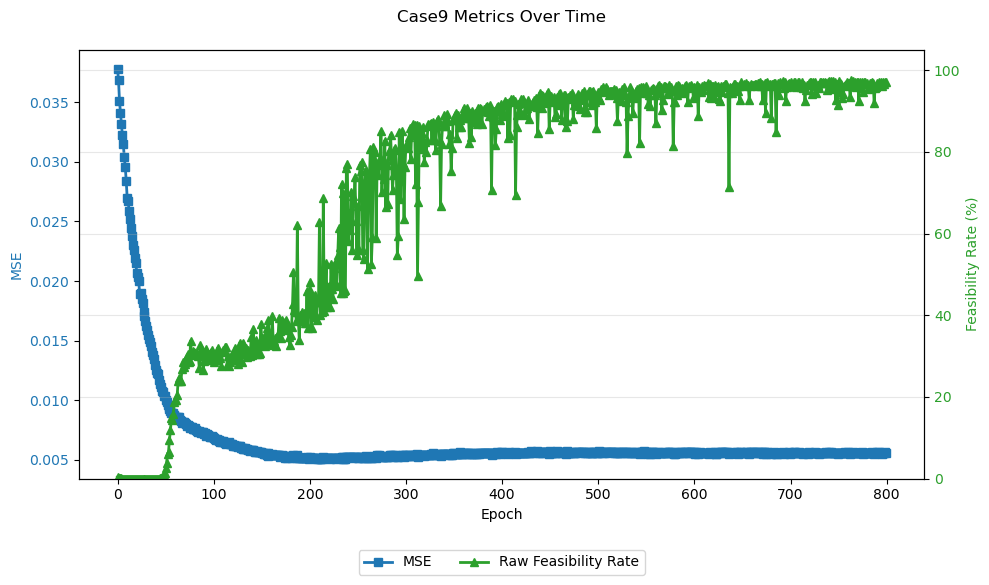

In [84]:
# Visualization of the validation
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have these lists:
# test_losses = [...]         # List of loss values
# test_mses = [...]           # List of MSE values (100 values)
# raw_feasibility_rates = [...]  # List of feasibility rates (100 values, 0-100%)

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Sample every n epochs
sample_interval = 10
x_vals = np.arange(0, len(test_mses), sample_interval)
sampled_mses = test_mses[::sample_interval]
sampled_feas = raw_feasibility_rates[::sample_interval]

# Plot MSE (left y-axis, changed to blue)
color_mse = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE', color=color_mse)
line_mse, = ax1.plot(x_vals, sampled_mses, 's-', color=color_mse, label='MSE', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color_mse)

# Create secondary y-axis for Feasibility Rate
ax2 = ax1.twinx()
color_feas = 'tab:green'
ax2.set_ylabel('Feasibility Rate (%)', color=color_feas)
line_feas, = ax2.plot(x_vals, sampled_feas, '^-', color=color_feas, label='Raw Feasibility Rate', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color_feas)
ax2.set_ylim(0, 105)  # Ensure full range is visible

# Combine legends from both axes
lines = [line_mse, line_feas]
ax1.legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.title('Case9 Metrics Over Time', pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# End of the current version